In [1]:
TRAIN = '/kaggle/input/fighter-planes-classification-dataset/fighter'

We want to use image embeddings for both EDA and classification, so let's add some code that will get those for us, using ResNeXt.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:02<00:00, 34.4MB/s]


Next let's load up all of our data, including image embeddings and thumbnails. We don't have a lot of data, so we can load it all.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if input_file.endswith('.jpeg')]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 172 rows of su57  in 0:00:25.422307
encoded 241 rows of f35  in 0:00:34.147048
done in 0:00:59.612393


Our target class is unbalanced. How unbalanced is it?

In [4]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag,f35,su57
proportion,0.583535,0.416465


F-35s outnumber Su-57s about three to two. Our target class is moderately unbalanced. Unfortunately, with so little data there's not much we can do other than be careful to stratify when we choose our train/test splits.

Let's use TSNE to add x/y coordinates based on our image embeddings.

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 413 samples in 0.003s...
[t-SNE] Computed neighbors for 413 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 413 / 413
[t-SNE] Mean sigma: 2.105937
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.902081
[t-SNE] KL divergence after 1000 iterations: 1.076552


Now we're ready to plot.

In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: fighter planes', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=6, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? First of all, we see that we don't have a lot of duplicate images, which is nice. Unfortunately, TSNE doesn't separate our two classes neatly, but for the most part any particular instance has mostly neighbors from the same class, which suggests we should see relatively high accuracy from our model, which will be a little inflated due to the presence of duplicate images. Let's build a model and take a look.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.2, random_state=2024, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=200, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 108 iterations
accuracy: 0.9036
f1: 0.9011
              precision    recall  f1-score   support

         f35       0.86      1.00      0.92        48
        su57       1.00      0.77      0.87        35

    accuracy                           0.90        83
   macro avg       0.93      0.89      0.90        83
weighted avg       0.92      0.90      0.90        83



What do we see? Our model has perfect precision for one class and perfect recall for the other, and our f1 seems to be a bit impacted by the class imbalance. But honestly an f1 of 0.9 isn't bad for so little effort.

What does our confusion matrix look like?

<Axes: >

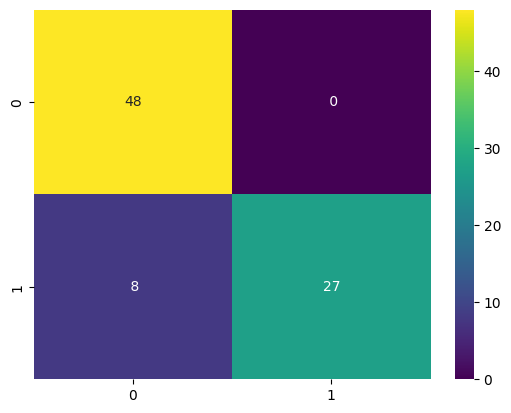

In [8]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

heatmap(annot=True, data=pd.DataFrame(data=confusion_matrix(y_true=y_test, y_pred=logreg.predict(X=X_test), ),), cmap='viridis', fmt='2')

Interestingly, our model sometimes confuses Su-57s for F-35s, but never the other way around. Let's take a look at our model probabilities.

<Axes: xlabel='x', ylabel='y'>

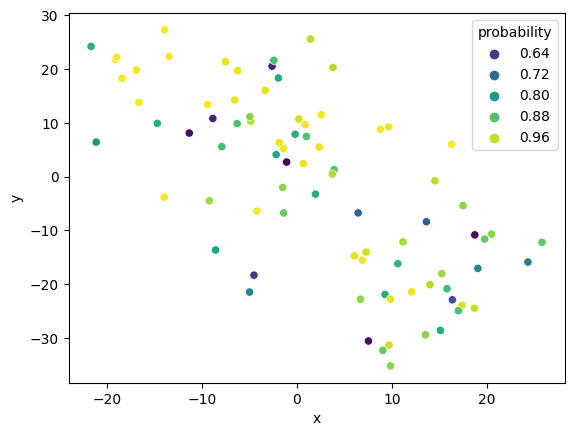

In [9]:
from seaborn import scatterplot

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)
scatterplot(data=plot_df, x='x', y='y', hue='probability', palette='viridis')

We don't have a lot of really high model probabilities, and we have a fair number of relatively small model probabilities. In other words, our model is doing reasonably well in the presence of fairly difficult data.